In [1]:
# import os
# import tensorflow as tf

# # Set CUDA device order and visible devices
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7,8,9"

# # Set the device
# device = '/cpu:0'
# if tf.config.experimental.list_physical_devices('GPU'):
#     try:
#         # Restrict TensorFlow to only use the second GPU
#         gpus = tf.config.experimental.list_physical_devices('GPU')
#         if gpus:
#             tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
#             device = '/gpu:0'
#     except RuntimeError as e:
#         print(e)

# print("device", device)


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2"  # Only GPUs 0 and 1 will be visible to TensorFlow

import tensorflow as tf
strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1","/gpu:2"])
# strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2')


2024-10-08 19:27:19.838577: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79196 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:45:00.0, compute capability: 8.0
2024-10-08 19:27:19.852347: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 79196 MB memory:  -> device: 1, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:46:00.0, compute capability: 8.0
2024-10-08 19:27:19.853817: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 79194 MB memory:  -> device: 2, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:49:00.0, compute capability: 8.0


In [3]:
import numpy as np
import matplotlib.pyplot as plt

import h5py
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, callbacks


In [4]:

# -----------------------------
# DataLoader Class Definition
# -----------------------------
class DataLoader:
    def __init__(self, h5_filename):
        self.h5_filename = h5_filename
        self.images, self.centers = self.load_data()

    def load_data(self):
        with h5py.File(self.h5_filename, 'r') as f:
            images = np.array(f['images'])
            centers = np.array(f['centers_training'])
        return images, centers

    def plot_image_with_centers(self, image_index=None):
        if image_index is None:
            image_index = np.random.randint(0, len(self.images))

        image = self.images[image_index]
        centers = self.centers[image_index]

        plt.imshow(image, cmap='gray')
        valid_centers = centers[centers[:, 0] == 1]
        for center in valid_centers:
            plt.scatter(center[1], center[2], c='red', marker='x')  # center[1] is x and center[2] is y
        plt.title('Image with Valid Centers Marked')
        plt.colorbar()
        plt.show()

    @staticmethod
    def sort_centers(centers):
        return centers[np.lexsort((centers[:, 0], centers[:, 1]))]

    def normalize_data(self):
        normalized_images = self.images / np.max(self.images)
        sorted_centers = np.array([self.sort_centers(image_centers[:, 1:]) for image_centers in self.centers])
        normalized_centers = sorted_centers / 64

        normalized_midpoints = tf.expand_dims(normalized_centers, axis=1)
        return normalized_images, normalized_midpoints.numpy()

    def split_data(self, train_size=0.8, random_state=42):
        normalized_images, normalized_midpoints_np = self.normalize_data()
        return train_test_split(normalized_images, normalized_midpoints_np, train_size=train_size, random_state=random_state)


In [5]:

# -----------------------------
# Utility Function Definition
# -----------------------------
def plot_transposed_images_with_midpoints(dataset, image_indices=[0, 1, 2, 3]):
    """
    Extracts multiple images and their midpoints from the given dataset, transposes the images, 
    corrects the midpoints, and plots the transposed images with the corrected midpoints.

    Args:
    - dataset (tf.data.Dataset): The dataset from which to extract the images and midpoints.
    - image_indices (list): The indices of the images in the batch to visualize. Default is [0, 1, 2, 3].
    """

    # Extract a sample image batch and its corresponding midpoints from the dataset
    sample_image_batch, sample_midpoints_batch = next(iter(dataset))

    # Create a figure with 2x2 subplots
    fig, axes = plt.subplots(2, 2, figsize=(6, 6))

    for i, ax in enumerate(axes.flat):
        if i < len(image_indices):
            # Select the specified image and corresponding midpoints from the batch
            sample_image = np.array(sample_image_batch[image_indices[i]])
            sample_midpoints = np.array(sample_midpoints_batch[image_indices[i]])

            # Transpose the image
            transposed_image = sample_image.T

            # Correct the midpoints by swapping the x and y coordinates
            transposed_midpoints_corrected = sample_midpoints[:, :, [1, 0]]

            # Plot the transposed image with corrected midpoints
            ax.imshow(transposed_image, cmap='gray')
            ax.scatter(
                transposed_midpoints_corrected[:, :, 0] * 64, 
                transposed_midpoints_corrected[:, :, 1] * 64, 
                c='red', marker='o', s=5
            )
            ax.set_title(f'Image {image_indices[i]} for this batch')
        else:
            ax.axis('off')  # If fewer than 4 images are requested, hide the unused subplots

    plt.tight_layout()
    plt.show()

# -----------------------------
# Custom Loss and Callback Definitions
# -----------------------------
@tf.keras.utils.register_keras_serializable()
def custom_loss(exponent):
    def loss(y_true, y_pred):
        diff = tf.abs(y_true - y_pred)
        powered_diff = tf.pow(diff, exponent)
        return tf.reduce_mean(powered_diff)
    return loss

@tf.keras.utils.register_keras_serializable()
class DynamicExponentCallback(tf.keras.callbacks.Callback):
    def __init__(self, initial_exponent, increment, update_frequency):
        super().__init__()
        self.exponent = initial_exponent
        self.increment = increment
        self.update_frequency = update_frequency

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.update_frequency == 0:
            self.exponent += self.increment
            print(f"\nEpoch {epoch + 1}: Increasing exponent to {self.exponent}")
            self.model.loss = self.custom_loss(self.exponent)

    def custom_loss(self, exponent):
        def loss(y_true, y_pred):
            diff = tf.abs(y_true - y_pred)
            powered_diff = tf.pow(diff, exponent)
            return tf.reduce_mean(powered_diff)
        return loss

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'initial_exponent': self.exponent,
            'increment': self.increment,
            'update_frequency': self.update_frequency,
        })
        return config


my NEW model

In [15]:
# from tensorflow.keras import layers, regularizers

# class ModelBuilder:
#     def __init__(self, input_shape=(64, 64, 1), num_classes=3, num_coordinates=2, learning_rate=3e-5, weights_path=None, l2_reg=0.001):
#         self.input_shape = input_shape
#         self.num_classes = num_classes
#         self.num_coordinates = num_coordinates
#         self.learning_rate = learning_rate
#         self.l2_reg = l2_reg
#         self.model = self.build_model()

#         # Load weights if a path is provided
#         if weights_path is not None:
#             self.model.load_weights(weights_path)

#         self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
#         # self.optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

#     def build_model(self):
#         l2 = regularizers.l2(self.l2_reg)
        
#         x_input = layers.Input(shape=self.input_shape)
        
#         # First branch
#         x_1 = layers.Conv2D(64, kernel_size=6, strides=1, padding='same', activation='relu')(x_input)
#         x_1 = layers.Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu')(x_1)
#         x_1 = layers.Conv2D(16, kernel_size=3, strides=1, padding='same', activation='relu')(x_1)
#         x_1 = layers.Conv2D(16, kernel_size=3, strides=3, padding='same', activation='relu', kernel_regularizer=l2)(x_1)
#         # x_1 = layers.Dropout(0.1)(x_1)
#         # x_1 = layers.BatchNormalization()(x_1)

#         # Second branch
#         x_2 = layers.Conv2D(32, kernel_size=8, strides=3, padding='same', activation='relu')(x_input)
#         x_2 = layers.Conv2D(64, kernel_size=4, strides=1, padding='same', activation='relu')(x_2)
#         x_2 = layers.Conv2D(16, kernel_size=3, strides=1, padding='same', activation='relu', kernel_regularizer=l2)(x_2)
#         # x_2 = layers.Dropout(0.1)(x_2)
#         # x_2 = layers.BatchNormalization()(x_2)

#         # Concatenate branches
#         x_3 = layers.concatenate([x_1, x_2])
#         x_3 = layers.Conv2D(16, kernel_size=3, strides=1, padding='same', activation='relu')(x_3)
#         x_3 = layers.Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu')(x_3)
#         x_3 = layers.Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu', kernel_regularizer=l2)(x_3)
#         # x_3 = layers.Dropout(0.1)(x_3)
#         # x_3 = layers.BatchNormalization()(x_3)

#         # Third branch
#         x_4 = layers.Conv2D(64, kernel_size=19, strides=5, padding='same', activation='relu', kernel_regularizer=l2)(x_input)
        
#         # Flatten and concatenate
#         x_3 = layers.Flatten()(x_3)
#         x_4 = layers.Flatten()(x_4)
#         x = layers.Concatenate()([x_3, x_4])

#         # Dense layers with L2 regularization
#         x = layers.Dense(256, activation='relu', kernel_regularizer=l2)(x)
#         # x = layers.Dropout(0.1)(x)

#         # Output layer for midpoints
#         x_midpoints = layers.Dense(self.num_classes * self.num_coordinates, activation='sigmoid', name='x_midpoints')(x)
#         x_midpoints_reshape = layers.Reshape((-1, self.num_classes, self.num_coordinates), name='x_midpoints_reshape')(x_midpoints)
        
#         return tf.keras.models.Model(x_input, x_midpoints_reshape)

#     def compile_model(self, loss_function):
#         self.model.compile(optimizer=self.optimizer, loss=loss_function)

#     def train_model(self, train_dataset, val_dataset, epochs, callbacks_list):
#         history = self.model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, callbacks=callbacks_list)
#         return history


In [6]:

from tensorflow.keras import layers, regularizers


class ModelBuilder:
    def __init__(self, input_shape=(64, 64, 1), num_classes=13, num_coordinates=2, learning_rate=1e-3, weights_path=None,l1_reg=0.001,l2_reg =0.01):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.num_coordinates = num_coordinates
        self.learning_rate = learning_rate
        self.l1_reg = l1_reg
        self.l2_reg = l2_reg
        self.model = self.build_model()

        # Load weights if a path is provided
        if weights_path is not None:
            self.model.load_weights(weights_path)

        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        # self.optimizer =tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

    def build_model(self):
        
        l1 = regularizers.l1(self.l1_reg)
        l2 = regularizers.l2(self.l2_reg)

    
        x_input = layers.Input(shape=self.input_shape)
        
        
        x = layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')(x_input)
        x = layers.MaxPool2D()(x)
        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')(x)
        
        x = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')(x)
        x = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')(x)
        # x = layers.Dropout(0.2)(x)
        x = layers.BatchNormalization()(x)
        
        x = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')(x)
        x = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')(x)
        # x = layers.Dropout(0.2)(x)
        x = layers.BatchNormalization()(x)
        
        
        x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x)
        x = layers.MaxPool2D()(x)
        # x = layers.Dropout(0.3)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x)
        x = layers.MaxPool2D()(x)
        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x)
        x = layers.MaxPool2D()(x)
        # x = layers.Dropout(0.3)(x)
        x = layers.BatchNormalization()(x)
        
        x = layers.Conv2D(256, kernel_size=5, padding='same', activation='relu')(x)
        x = layers.MaxPool2D()(x)
        # x = layers.Dropout(0.2)(x)
        x = layers.BatchNormalization()(x)
        
        x = layers.Flatten()(x)
        
        x_midpoints = layers.Dense(self.num_classes * self.num_coordinates, activation='linear', name='x_midpoints')(x)
        x_midpoints_reshape = layers.Reshape((-1, self.num_classes, self.num_coordinates), name='x_midpoints_reshape')(x_midpoints)
        
        return tf.keras.models.Model(x_input, x_midpoints_reshape)

    def compile_model(self, loss_function):
        self.model.compile(optimizer=self.optimizer, loss=loss_function)

    def train_model(self, train_dataset, val_dataset, epochs, callbacks_list):
        history = self.model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, callbacks=callbacks_list)
        return history


In [7]:

# -----------------------------
# Main Script Execution
# -----------------------------

# Load data
# h5_filename = '/home/da886/Final Electron counting project/Images and Labels/30KFixed_Mixed_13.h5'             
h5_filename = '/home/da886/Final Electron counting project/Images and Labels/30KNoFalsePositivesFixed-index6_13.h5'
data_loader = DataLoader(h5_filename)
images, centers = data_loader.load_data()


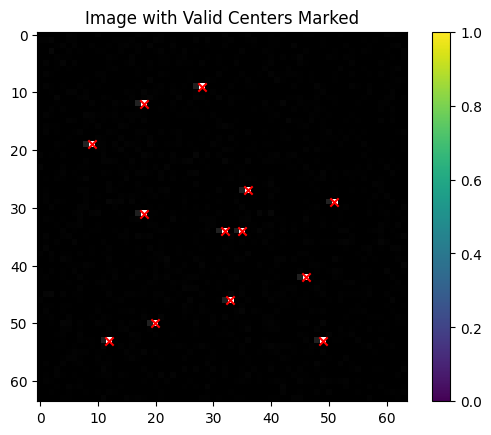

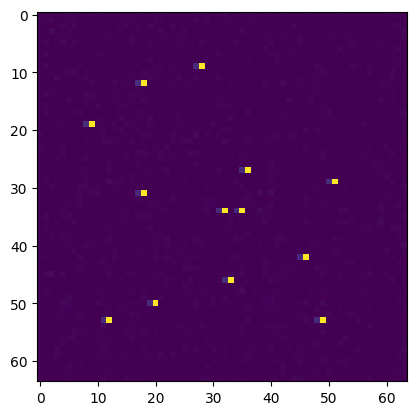

In [8]:
l=np.random.randint(0,len(centers))
data_loader.plot_image_with_centers(l)
plt.imshow(images[l])

In [9]:

# Normalize the data and split it into training and validation sets
train_images, val_images, train_midpoints, val_midpoints = data_loader.split_data()

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_midpoints))
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_midpoints))


In [10]:

batch_size = 500
train_dataset = train_dataset.shuffle(buffer_size=8000, reshuffle_each_iteration=True).batch(batch_size)
val_dataset = val_dataset.shuffle(buffer_size=8000).batch(batch_size)

# Check the shape of the datasets
print(f'Train Images: {train_images.shape}, Train Midpoints: {train_midpoints.shape}')
print(f'Validation Images: {val_images.shape}, Validation Midpoints: {val_midpoints.shape}')


Train Images: (24000, 64, 64), Train Midpoints: (24000, 1, 13, 2)
Validation Images: (6000, 64, 64), Validation Midpoints: (6000, 1, 13, 2)


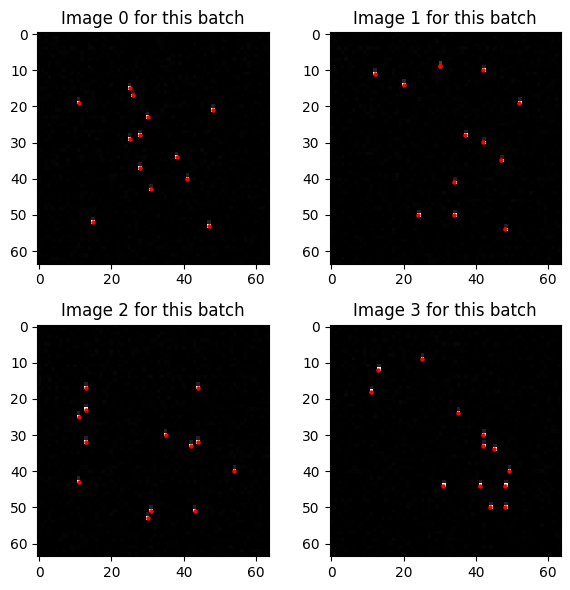

In [11]:
plot_transposed_images_with_midpoints(train_dataset, image_indices=[0, 1, 2, 3])

In [12]:


# Set up learning rate scheduler
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.9, patience=13, verbose=1, mode='min', min_lr=7e-6
)


In [24]:

# dynamic_exponent_callback = DynamicExponentCallback(2, 1, 50)


with strategy.scope():
    # Instantiate the model builder
    # model_builder = ModelBuilder(weights_path= "/home/da886/Weights from Josh's model/Josh's5fixedMSE45overfit-1.keras")
    model_builder = ModelBuilder()

    # Build the model
    model_builder.build_model()

    # Display the model architecture
    model_builder.model.summary()

    # Compile the model using the custom loss function
    # model_builder.compile_model(loss_function=dynamic_exponent_callback.custom_loss(2))
    model_builder.compile_model(loss_function=tf.keras.losses.MeanSquaredError()) 
    
    # model_builder.compile_model(loss_function=custom_loss(3))e




Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 4, 4, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 4, 4, 256)      │     3,277,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 2, 2, 256)      │             

 Total params: 10,356,698 (39.51 MB)

 Trainable params: 10,352,218 (39.49 MB)

 Non-trainable params: 4,480 (17.50 KB)

In [25]:

# Train the model with the custom callback
history = model_builder.train_model(
    train_dataset, 
    val_dataset, 
    epochs=1100,
    callbacks_list=[lr_scheduler]
)


Epoch 1/1100


2024-10-07 21:17:11.027321: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-10-07 21:17:11.039600: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-10-07 21:17:11.066419: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
W0000 00:00:1728335831.161143 2784221 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728335831.161143 2784172 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728335831.163488 2784217 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728335831.227322 2784172 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728335831.227414 2784217 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728335831.227466 2784221 gpu_timer.c

 1/48 ━━━━━━━━━━━━━━━━━━━━ 22:51 29s/step - loss: 2.1473

W0000 00:00:1728335841.128811 2784221 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728335841.129411 2784221 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728335841.130030 2784221 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728335841.130663 2784221 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728335841.131278 2784221 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728335841.131876 2784221 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728335841.132495 2784221 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728335841.133124 2784221 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728335841.133773 2784221 gp

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 3.4169

2024-10-07 21:17:24.974825: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-10-07 21:17:24.974922: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-10-07 21:17:24.975079: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
W0000 00:00:1728335847.910769 2784192 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728335847.910766 2784208 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728335847.911059 2784179 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00

48/48 ━━━━━━━━━━━━━━━━━━━━ 41s 253ms/step - loss: 3.3712 - val_loss: 2.0678 - learning_rate: 0.0010
Epoch 2/1100


2024-10-07 21:17:33.078653: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0600

2024-10-07 21:17:37.358109: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/step - loss: 0.0599 - val_loss: 0.9899 - learning_rate: 0.0010
Epoch 3/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/step - loss: 0.0408 - val_loss: 1.9264 - learning_rate: 0.0010
Epoch 4/1100


2024-10-07 21:17:44.161600: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step - loss: 0.0324 - val_loss: 1.9825 - learning_rate: 0.0010
Epoch 5/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step - loss: 0.0278 - val_loss: 1.7505 - learning_rate: 0.0010
Epoch 6/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0251

2024-10-07 21:17:59.327343: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - loss: 0.0251 - val_loss: 1.4857 - learning_rate: 0.0010
Epoch 7/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - loss: 0.0229 - val_loss: 1.5278 - learning_rate: 0.0010
Epoch 8/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - loss: 0.0215 - val_loss: 1.7289 - learning_rate: 0.0010
Epoch 9/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - loss: 0.0202 - val_loss: 2.0054 - learning_rate: 0.0010
Epoch 10/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - loss: 0.0200 - val_loss: 2.2020 - learning_rate: 0.0010
Epoch 11/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step - loss: 0.0196 - val_loss: 2.4973 - learning_rate: 0.0010
Epoch 12/1100


2024-10-07 21:18:28.814729: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - loss: 0.0190 - val_loss: 2.6672 - learning_rate: 0.0010
Epoch 13/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - loss: 0.0185 - val_loss: 2.3772 - learning_rate: 0.0010
Epoch 14/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - loss: 0.0179 - val_loss: 1.8331 - learning_rate: 0.0010
Epoch 15/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0177
Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0009000000427477062.
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - loss: 0.0177 - val_loss: 1.1997 - learning_rate: 0.0010
Epoch 16/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - loss: 0.0173 - val_loss: 0.5704 - learning_rate: 9.0000e-04
Epoch 17/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 109ms/step - loss: 0.0169 - val_loss: 0.0941 - learning_rate: 9.0000e-04
Epoch 18/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - loss: 0.0170 - val_loss: 0.0465 - learning_rate: 9.0000e-04
Epoch 19/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 115ms/step - loss: 0.0167 - val_los

2024-10-07 21:19:28.184969: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - loss: 0.0165 - val_loss: 0.0185 - learning_rate: 9.0000e-04
Epoch 23/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step - loss: 0.0163 - val_loss: 0.0164 - learning_rate: 9.0000e-04
Epoch 24/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 110ms/step - loss: 0.0163 - val_loss: 0.0169 - learning_rate: 9.0000e-04
Epoch 25/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - loss: 0.0163 - val_loss: 0.0170 - learning_rate: 9.0000e-04
Epoch 26/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - loss: 0.0162 - val_loss: 0.0195 - learning_rate: 9.0000e-04
Epoch 27/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - loss: 0.0163 - val_loss: 0.0162 - learning_rate: 9.0000e-04
Epoch 28/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - loss: 0.0161 - val_loss: 0.0167 - learning_rate: 9.0000e-04
Epoch 29/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 109ms/step - loss: 0.0158 - val_loss: 0.0167 - learning_rate: 9.0000e-04
Epoch 30/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - loss: 0.0159 - val_los

2024-10-07 21:21:25.552786: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - loss: 0.0149 - val_loss: 0.0157 - learning_rate: 9.0000e-04
Epoch 45/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - loss: 0.0151 - val_loss: 0.0162 - learning_rate: 9.0000e-04
Epoch 46/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - loss: 0.0150 - val_loss: 0.0153 - learning_rate: 9.0000e-04
Epoch 47/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - loss: 0.0150 - val_loss: 0.0159 - learning_rate: 9.0000e-04
Epoch 48/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - loss: 0.0150 - val_loss: 0.0167 - learning_rate: 9.0000e-04
Epoch 49/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step - loss: 0.0148 - val_loss: 0.0161 - learning_rate: 9.0000e-04
Epoch 50/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - loss: 0.0150 - val_loss: 0.0158 - learning_rate: 9.0000e-04
Epoch 51/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - loss: 0.0146 - val_loss: 0.0155 - learning_rate: 9.0000e-04
Epoch 52/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - loss: 0.0147 - val_lo

2024-10-07 21:25:22.362787: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - loss: 0.0117 - val_loss: 0.0161 - learning_rate: 8.1000e-04
Epoch 87/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - loss: 0.0115 - val_loss: 0.0143 - learning_rate: 8.1000e-04
Epoch 88/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/step - loss: 0.0117 - val_loss: 0.0142 - learning_rate: 8.1000e-04
Epoch 89/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - loss: 0.0113 - val_loss: 0.0149 - learning_rate: 8.1000e-04
Epoch 90/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step - loss: 0.0111 - val_loss: 0.0151 - learning_rate: 8.1000e-04
Epoch 91/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - loss: 0.0111 - val_loss: 0.0142 - learning_rate: 8.1000e-04
Epoch 92/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step - loss: 0.0110 - val_loss: 0.0142 - learning_rate: 8.1000e-04
Epoch 93/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - loss: 0.0109 - val_loss: 0.0144 - learning_rate: 8.1000e-04
Epoch 94/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - loss: 0.0112 - val_lo

2024-10-07 21:33:14.732669: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - loss: 0.0017 - val_loss: 0.0146 - learning_rate: 4.3047e-04
Epoch 173/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step - loss: 0.0015 - val_loss: 0.0143 - learning_rate: 4.3047e-04
Epoch 174/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0016
Epoch 174: ReduceLROnPlateau reducing learning rate to 0.00038742052274756136.
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - loss: 0.0016 - val_loss: 0.0143 - learning_rate: 4.3047e-04
Epoch 175/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - loss: 0.0016 - val_loss: 0.0144 - learning_rate: 3.8742e-04
Epoch 176/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - loss: 0.0015 - val_loss: 0.0143 - learning_rate: 3.8742e-04
Epoch 177/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 7s 120ms/step - loss: 0.0015 - val_loss: 0.0146 - learning_rate: 3.8742e-04
Epoch 178/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - loss: 0.0016 - val_loss: 0.0137 - learning_rate: 3.8742e-04
Epoch 179/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step -

2024-10-07 21:48:43.489885: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - loss: 3.9968e-04 - val_loss: 0.0123 - learning_rate: 1.2158e-04
Epoch 344/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step - loss: 3.9986e-04 - val_loss: 0.0122 - learning_rate: 1.2158e-04
Epoch 345/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - loss: 4.4231e-04 - val_loss: 0.0126 - learning_rate: 1.2158e-04
Epoch 346/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step - loss: 3.7533e-04 - val_loss: 0.0123 - learning_rate: 1.2158e-04
Epoch 347/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - loss: 3.8774e-04 - val_loss: 0.0122 - learning_rate: 1.2158e-04
Epoch 348/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - loss: 3.9437e-04 - val_loss: 0.0123 - learning_rate: 1.2158e-04
Epoch 349/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - loss: 4.2905e-04 - val_loss: 0.0125 - learning_rate: 1.2158e-04
Epoch 350/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step - loss: 4.2260e-04 - val_loss: 0.0121 - learning_rate: 1.2158e-04
Epoch 351/1100
48/48 ━━━━━━━━━━━━━━━━━━

2024-10-07 22:20:02.938237: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - loss: 7.8089e-05 - val_loss: 0.0122 - learning_rate: 8.7280e-06
Epoch 685/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - loss: 6.7529e-05 - val_loss: 0.0119 - learning_rate: 8.7280e-06
Epoch 686/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - loss: 7.1337e-05 - val_loss: 0.0119 - learning_rate: 8.7280e-06
Epoch 687/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - loss: 7.0523e-05 - val_loss: 0.0118 - learning_rate: 8.7280e-06
Epoch 688/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - loss: 7.6944e-05 - val_loss: 0.0119 - learning_rate: 8.7280e-06
Epoch 689/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - loss: 7.1836e-05 - val_loss: 0.0122 - learning_rate: 8.7280e-06
Epoch 690/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - loss: 6.6438e-05 - val_loss: 0.0119 - learning_rate: 8.7280e-06
Epoch 691/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - loss: 7.5863e-05 - val_loss: 0.0118 - learning_rate: 8.7280e-06
Epoch 692/1100
48/48 ━━━━━━━━━━━━━━━━━━

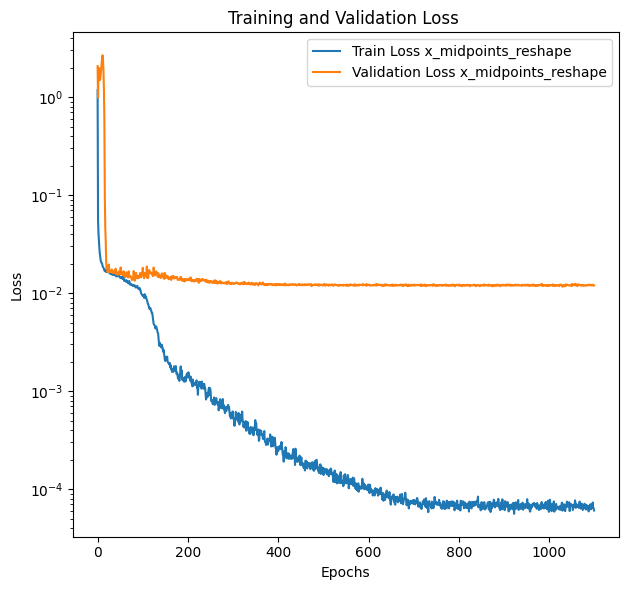

In [26]:


# Extract the losses from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']


train_loss_x_midpoints = history.history.get('x_midpoints_reshape_loss', train_loss)
val_loss_x_midpoints = history.history.get('val_x_midpoints_reshape_loss', val_loss)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2,1)
plt.plot(train_loss_x_midpoints, label='Train Loss x_midpoints_reshape')
plt.plot(val_loss_x_midpoints, label='Validation Loss x_midpoints_reshape')
plt.xlabel('Epochs')
plt.yscale('log')

plt.ylabel('Loss')
plt.title('Training and Validation Loss ')
plt.legend()

plt.tight_layout()
plt.show()


In [41]:
model_builder.model.save("/home/da886/Analysis/30KNoFalsePositivesFixed-index6_13__overfitlonger.keras")
# loaded_model = tf.keras.models.load_model(
# "/home/da886/Final Electron counting project/Trained weights/Fixed weights/13overfitoriginalmodelgeneralized.keras",
# )

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Define the function for visualizing midpoints
def visualize_midpoints(image, midpoints, title="Predicted Midpoint Visualization"):
    """
    Visualizes midpoints on an image without using a probability vector.

    Parameters:
    - image: A 3D tensor representing the image.
    - midpoints: A 2D tensor representing the midpoint coordinates (x, y).
    - title: The title of the plot.

    Returns:
    None (displays the image with midpoints).
    """
    # Convert to NumPy arrays for easier handling
    image_np = image
    midpoints_np = midpoints

    # Denormalize image if necessary (adjust based on your normalization method)
    denormalized_image = image_np  # Modify if normalization was applied during training

    # Visualize the image
    plt.figure(figsize=(4, 4))
    plt.imshow(denormalized_image, cmap='gray')
    plt.title(title)

    # Plot midpoints directly, only if they are not (0, 0)
    for i, (x, y) in enumerate(midpoints_np):
        if x >= 3 and y >= 3:  # Only plot if the point is not (0, 0)
            plt.scatter(x, y, color='red', s=5)

    plt.show()

# # Create the validation dataset
# val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_midpoints))
# val_dataset = val_dataset.batch(800)
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_midpoints))
train_dataset = train_dataset.batch(800)
# inputs,targets = next(iter(train_dataset))
# outputs = model_builder.model.predict(inputs)
# # Initialize lists to collect the data
all_images = []
all_true_midpoints = []
all_pred_midpoints = []

# # Loop through each batch in the validation dataset, predict, and collect results
# for i, (data_batch, midpoints_batch) in enumerate(val_dataset):

for i, (data_batch, midpoints_batch) in enumerate(train_dataset):
    print(f"Processing batch {i + 1}, batch shape: {data_batch.shape}")
    
    # Get the model predictions
    predictions = model_builder.model.predict(data_batch)

    # Extend the lists to store data from each batch
    all_images.extend(data_batch.numpy())  # Store all images
    all_true_midpoints.extend(midpoints_batch.numpy())  # Store all true midpoints
    all_pred_midpoints.extend(predictions)  # Store all predicted midpoints

# Convert lists to arrays for easier indexing
all_images = np.array(all_images)
all_true_midpoints = np.array(all_true_midpoints)
all_pred_midpoints = np.array(all_pred_midpoints)


2024-10-08 19:26:47.032735: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-08 19:26:47.048495: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-08 19:26:47.062384: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-08 19:26:47.066425: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-08 19:26:47.079888: I tensorflow/core/platform/cpu_feature_guar

NameError: name 'train_images' is not defined

In [16]:
# train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_midpoints))
# train_dataset = train_dataset.batch(800)
# inputs,targets = next(iter(train_dataset))
# outputs = model_builder.model.predict(inputs)

In [28]:
all_images.shape,all_pred_midpoints.shape,all_true_midpoints.shape

((24000, 64, 64), (24000, 1, 13, 2), (24000, 1, 13, 2))

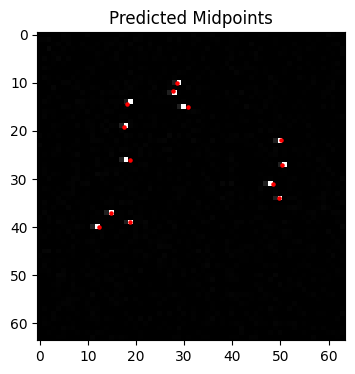

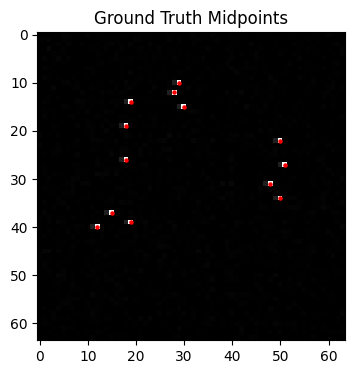

In [39]:

# Select an index to visualize from the entire dataset
index_to_visualize = np.random.randint(0, len(all_images))

# index_to_visualize = 11548
# Visualize the selected image with predicted and true midpoints
visualize_midpoints(all_images[index_to_visualize], all_pred_midpoints[index_to_visualize, 0, :, :] * 64, title="Predicted Midpoints")
visualize_midpoints(all_images[index_to_visualize], all_true_midpoints[index_to_visualize, 0, :, :] * 64, title="Ground Truth Midpoints")


In [43]:
np.min(all_pred_midpoints),np.max(all_pred_midpoints)

(0.00016376097, 0.9970034)

In [42]:
np.min(all_true_midpoints),np.max(all_true_midpoints)

(0.13964641, 0.84375)

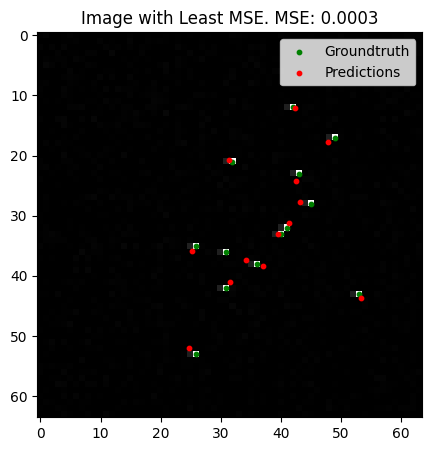

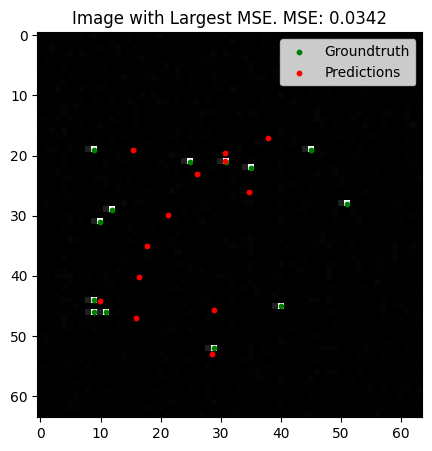

In [41]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize variables to track the min and max MSE
min_mse = float('inf')
max_mse = float('-inf')
min_mse_index = -1
max_mse_index = -1

# Loop through each prediction to calculate the MSE
for i in range(len(all_pred_midpoints)):
    mse = np.mean((all_pred_midpoints[i] - all_true_midpoints[i]) **2)
    
    if mse < min_mse:
        min_mse = mse
        min_mse_index = i
    
    if mse > max_mse:
        max_mse = mse
        max_mse_index = i
import numpy as np
import matplotlib.pyplot as plt

# Function to plot an image with its centers
def plot_image_with_centers(image, true_center, predicted_center, title):
    plt.figure(figsize=(5, 5))
    plt.imshow(image.squeeze(), cmap='gray')  # Display the image

    # Plot the actual center (Groundtruth)
    plt.scatter(true_center[:, 0], true_center[:, 1], color='green', label='Groundtruth', s=10)

    # Plot the predicted center
    plt.scatter(predicted_center[:, 0], predicted_center[:, 1], color='red', label='Predictions', s=10)

    plt.title(title)
    plt.legend()
    plt.show()






# Plotting the image with the least MSE
plot_image_with_centers(all_images[min_mse_index],
                        all_true_midpoints[min_mse_index][0] * 64,  # Adjust for scaling if needed
                        all_pred_midpoints[min_mse_index][0] * 64,  # Adjust for scaling if needed
                        f'Image with Least MSE. MSE: {min_mse:.4f}')

# Plotting the image with the largest MSE
plot_image_with_centers(all_images[max_mse_index],
                        all_true_midpoints[max_mse_index][0] * 64,  # Adjust for scaling if needed
                        all_pred_midpoints[max_mse_index][0] * 64,  # Adjust for scaling if needed
                        f'Image with Largest MSE. MSE: {max_mse:.4f}')




In [22]:
max_mse_index

5266